In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.rawio import BlackrockRawIO
from nilearn import plotting, datasets

In [2]:
# pull in OSort QC
df_preproc = pd.read_csv('../../results/202512/records/preproc.csv')[['channel', 'unit', 'keep']]
df_preproc['keep'] = df_preproc['keep'].fillna(0)
df_preproc

,channel,unit,keep
0,1,596,0.0
1,1,612,0.0
2,2,1432,0.0
3,2,1502,0.0
4,2,1543,0.0
...,...,...,...
85,30,156,0.0
86,31,182,0.0
87,31,188,0.0
88,32,167,0.0


In [3]:
# get [clustIDs] where df[keep] = 0
dropped_clustIDs = df_preproc[df_preproc['keep'] != 1]['unit'].tolist()
dropped_clustIDs.extend([0, 99999999])
print(dropped_clustIDs)

[596, 612, 1432, 1502, 1543, 506, 703, 636, 683, 1469, 2405, 2423, 2457, 2481, 1518, 1755, 1348, 1396, 1553, 1566, 1715, 1772, 976, 1042, 1045, 1433, 1799, 1825, 1953, 1712, 2185, 2769, 3203, 3227, 2308, 2323, 264, 571, 1998, 1747, 1901, 1921, 1585, 1736, 1558, 2261, 2280, 1663, 1678, 1373, 1882, 130, 147, 82, 117, 141, 163, 157, 172, 148, 151, 118, 156, 182, 188, 167, 174, 0, 99999999]


In [4]:
def getclustID2spikes(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    ID_spikes_dict = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in ID_spikes_dict: ID_spikes_dict[clustID] = [] # init

        ID_spikes_dict[clustID].append(spike)

    return ID_spikes_dict

## create df with: channel, clustID, spikes, #spikes, avgFR
 

In [5]:
samp_rate = 1000000
neur_spikes_df = []

data_dir = '../../results/202512/osort_mat/sort/5'

for channel_num in range(len(os.listdir(data_dir))):

    channel_mat = sio.loadmat(f'{data_dir}/A{channel_num+1}_sorted_new.mat')

    # get (1 * n_spikes) clusterID & spiketimes
    clust_IDs = channel_mat['assignedNegative'][0]
    spikes = channel_mat['newTimestampsNegative'][0]

    # get clusterID: [spikes]
    ID_spikes_dict = getclustID2spikes(clust_IDs, spikes)

    # 1 row per clustID
    clust_df = pd.DataFrame([
        {
            "channel": channel_num + 1,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in ID_spikes_dict.items()
    ])
    neur_spikes_df.append(clust_df)

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)


## old_channel -> new_channel -> region -> coordinates -> atlas regions

In [6]:
# old channels (1:32) -> new channels (97:128)
raw = BlackrockRawIO(filename="../../results/202512/raw/datafile_202512b002.ns6", nsx_to_load=[6])
raw.parse_header()

sig = raw.header['signal_channels']        # 1-D structured array
chan_ids   = sig['id'].astype(int)         # true Blackrock ChannelIDs (ordered)

old2new_chanID = dict(zip(range(1,33), chan_ids))
neur_spikes_df['old_channel'] = neur_spikes_df['channel'].copy()
neur_spikes_df['channel'] = neur_spikes_df['old_channel'].map(old2new_chanID).fillna(neur_spikes_df['old_channel']).astype(float)
print(np.unique(neur_spikes_df['channel']))
neur_spikes_df

[ 98. 101. 102. 103. 104. 105. 106. 107. 108. 109. 111. 112. 113. 116.]


,channel,clustID,spikes,#spikes,avgFR,old_channel
0,98.0,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,2
1,101.0,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,5
2,102.0,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,6
3,102.0,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,6
4,102.0,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,6
5,103.0,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,7
6,104.0,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269,8
7,104.0,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,8
8,105.0,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766,9
9,105.0,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493,9


In [7]:
# channels -> regions
channelInfo = sio.loadmat('../../results/202512/records/202512_DI_ChannelMap.mat')
channelMap = channelInfo['ChannelMap1'].flatten()
labelMap = channelInfo['LabelMap'].flatten()
labelMap = np.array([str(label.squeeze()) for label in labelMap])  # convert to str

# dict after removing nan keys
nan_mask = ~np.isnan(channelMap)
channel2label = dict(zip(channelMap[nan_mask], labelMap[nan_mask]))

neur_spikes_df['region'] = neur_spikes_df['channel'].map(channel2label).fillna(neur_spikes_df['channel']).apply(lambda x: str(x))
print(neur_spikes_df['region'].unique())


['mLOFC2' 'mLOFC5' 'mLOFC6' 'mLOFC7' 'mLOFC8' 'mLACC1' 'mLACC2' 'mLACC3'
 'mLACC4' 'mLACC5' 'mLACC7' 'mLACC8' 'mRHIP1' 'mRHIP4']


In [8]:
def clean_entry(x):
    while isinstance(x, (np.ndarray, list)):
        x = x[0]
    if isinstance(x, (bytes, bytearray)):
        x = x.decode("utf-8", errors="ignore")
    return str(x)

# load
electrodeInfo = sio.loadmat('../../results/202512/records/202512_DI_Electrodes.mat')
ElecMapRaw   = pd.DataFrame(electrodeInfo['ElecMapRaw'])
ElecXYZRaw   = pd.DataFrame(electrodeInfo['ElecXYZRaw'])
ElecAtlasRaw = pd.DataFrame(electrodeInfo['ElecAtlasRaw'])

atlas_index = 0 # NMM

# clean
region_s = ElecMapRaw[0].apply(clean_entry)                    # Series of regions
atlas_s  = ElecAtlasRaw.iloc[:, atlas_index].apply(clean_entry)  # Series of atlas regions

# build small tables
region2id_df = pd.DataFrame({"region": region_s.values,
                             "ID": np.arange(len(region_s))})
id2xyz_df = ElecXYZRaw.reset_index().rename(columns={'index':'ID', 0:'x', 1:'y', 2:'z'})
# xyz2atlasRegions = pd.DataFrame({"ID": np.arange(len(atlas_s)),
#                                  "atlas_region": atlas_s.values})

# merge
final_neur_df = (neur_spikes_df
                .merge(region2id_df, on='region', how='left')
                .merge(id2xyz_df, on='ID', how='left')
                # .merge(xyz2atlasRegions, on='ID', how='left')
                )
final_neur_df = final_neur_df.drop(columns=['ID'])

In [9]:
eg_spikes = final_neur_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
n_neurs = len(final_neur_df)
final_neur_df

last 5 spikes (s): [1620.1233     1620.19223333 1620.53116667 1620.94453333 1621.08233333]
last 5 spikes (min): [27.002055   27.00320389 27.00885278 27.01574222 27.01803889]


,channel,clustID,spikes,#spikes,avgFR,old_channel,region,x,y,z
0,98.0,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,2,mLOFC2,-0.111605,42.570655,-15.682235
1,101.0,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,5,mLOFC5,-1.311382,42.570655,-15.682235
2,102.0,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,6,mLOFC6,-2.511159,42.570655,-15.682235
3,102.0,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,6,mLOFC6,-2.511159,42.570655,-15.682235
4,102.0,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,6,mLOFC6,-2.511159,42.570655,-15.682235
5,103.0,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,7,mLOFC7,-2.511159,40.172309,-15.682235
6,104.0,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269,8,mLOFC8,-2.511159,41.371482,-15.682235
7,104.0,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,8,mLOFC8,-2.511159,41.371482,-15.682235
8,105.0,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766,9,mLACC1,-0.111605,32.977269,18.278047
9,105.0,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493,9,mLACC1,-0.111605,32.977269,18.278047


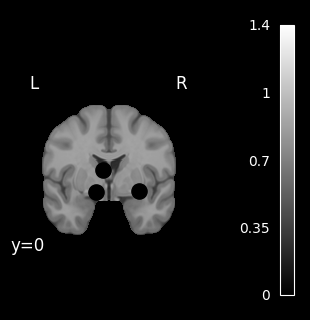

In [10]:
from nilearn import plotting, datasets
import numpy as np

template = datasets.load_mni152_template()
coords = np.array([[-12.3, 18.5, -10.0],
                   [ 30.1, -4.2,  -8.5],
                   [ -6.0, 52.0,  12.0]])

# pick a sagittal plane (y in MNI) to show
slice_y = 0.0

# project all points onto that plane (keep x,z; set y = slice_y)
coords_proj = coords.copy()
coords_proj[:, 1] = slice_y

# gray brain on black background, single sagittal slice at slice_y
disp = plotting.plot_anat(
    template,
    display_mode='y',
    cut_coords=[slice_y],
    cmap='gray',
    black_bg=True,
    draw_cross=False
)
disp.add_markers(coords_proj.tolist(), marker_size=120, marker_color='k')
plotting.show()


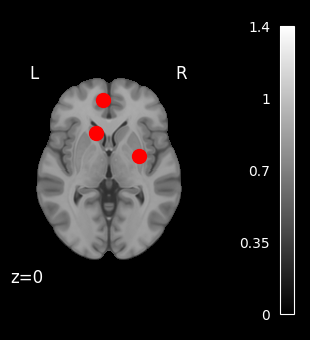

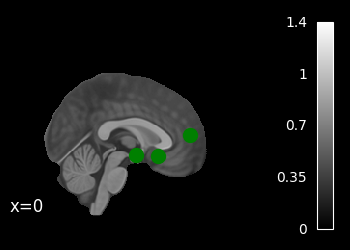

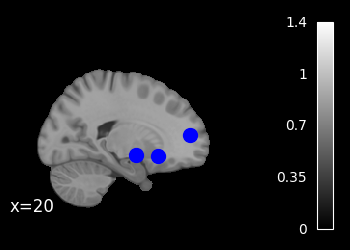

In [11]:
import numpy as np
from nilearn import plotting, datasets

template = datasets.load_mni152_template()
coords = np.array([[-12.3, 18.5, -10.0],
                   [ 30.1, -4.2,  -8.5],
                   [ -6.0, 52.0,  12.0]])

# --- Axial slice ---
axial_cut = 0   # z=0 plane
coords_ax = coords.copy()
coords_ax[:,2] = axial_cut

disp1 = plotting.plot_anat(
    template, display_mode='z', cut_coords=[axial_cut],
    cmap='gray', black_bg=True, draw_cross=False
)
disp1.add_markers(coords_ax.tolist(), marker_size=100, marker_color='red')

# --- First sagittal slice ---
sag1_cut = 0   # x=0 plane
coords_sag1 = coords.copy()
coords_sag1[:,0] = sag1_cut

disp2 = plotting.plot_anat(
    template, display_mode='x', cut_coords=[sag1_cut],
    cmap='gray', black_bg=True, draw_cross=False
)
disp2.add_markers(coords_sag1.tolist(), marker_size=100, marker_color='green')

# --- Second sagittal slice ---
sag2_cut = 20  # pick another x-plane
coords_sag2 = coords.copy()
coords_sag2[:,0] = sag2_cut

disp3 = plotting.plot_anat(
    template, display_mode='x', cut_coords=[sag2_cut],
    cmap='gray', black_bg=True, draw_cross=False
)
disp3.add_markers(coords_sag2.tolist(), marker_size=100, marker_color='blue')

plotting.show()


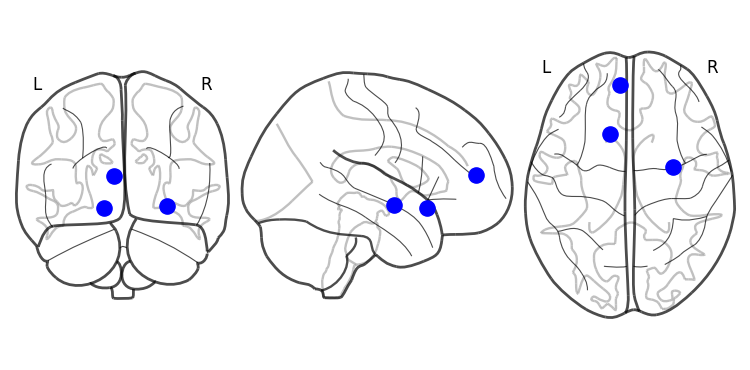

In [12]:
coords = np.array([[-12.3, 18.5, -10.0],
                   [ 30.1, -4.2,  -8.5],
                   [ -6.0, 52.0,  12.0]])

# No stat map ⇒ no red heatmap, just white “glass” outline
disp = plotting.plot_glass_brain(
    None,                      # <- key change
    display_mode="ortho",
    background_color='white'
)
disp.add_markers(coords.tolist(), marker_size=120, marker_color='b')
plotting.show()


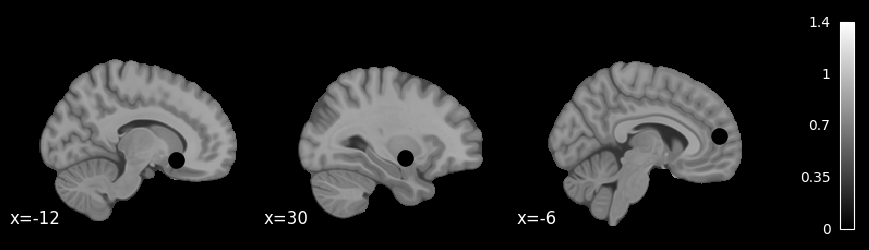

In [13]:
tmpl = datasets.load_mni152_template()

# X slices at your x-coordinates
disp = plotting.plot_anat(tmpl, display_mode='x', cmap='gray',
                          draw_cross=False, cut_coords=coords[:,0].tolist())
disp.add_markers(coords.tolist(), marker_size=120, marker_color='k')
plotting.show()


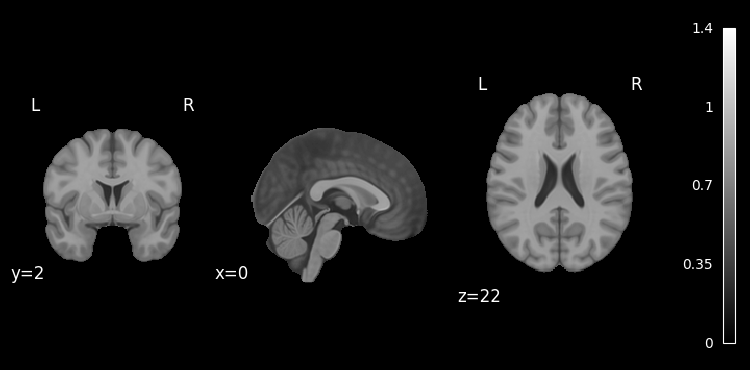

In [14]:
from nilearn import plotting, datasets
import numpy as np

template = datasets.load_mni152_template()
coords = np.array([[-12.3, 18.5, -10.0],
                   [ 30.1, -4.2,  -8.5],
                   [ -6.0, 52.0,  12.0]])

disp = plotting.plot_anat(
    template, 
    display_mode="ortho", 
    cmap='gray',  # <-- white/gray brain
    draw_cross=False
)
disp.add_markers([tuple(x) for x in coords],
                 marker_size=120, marker_color='k')
plotting.show()


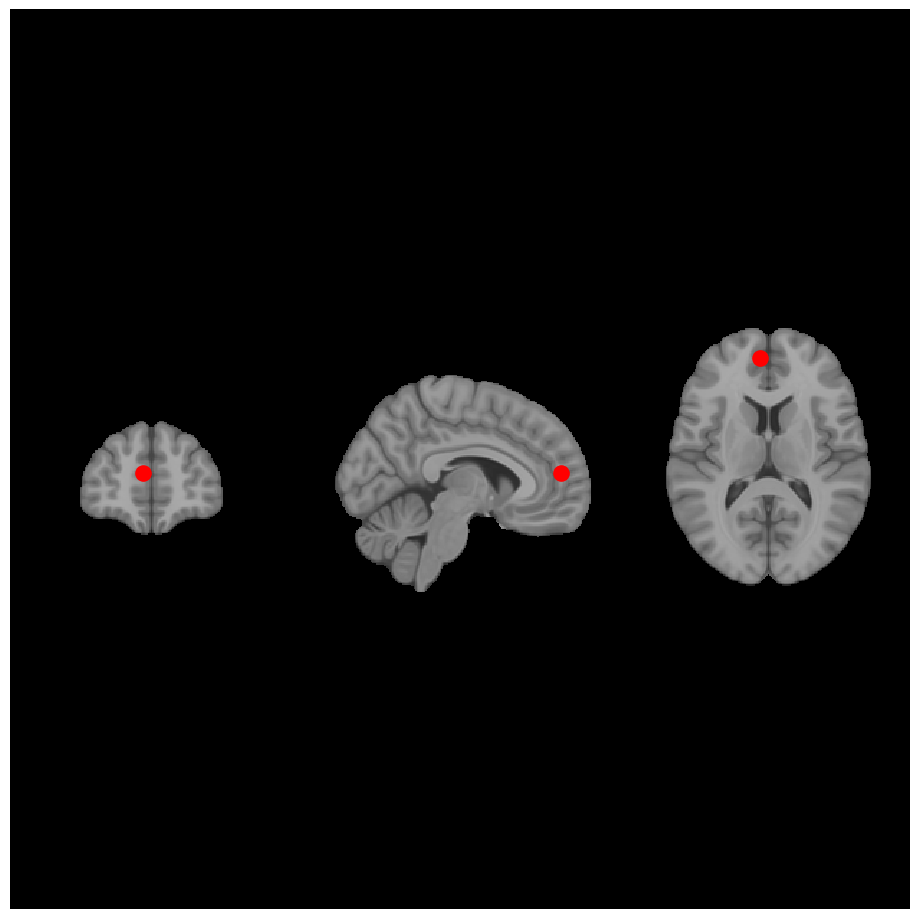

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets

template = datasets.load_mni152_template()
coords = np.array([[-12.3, 18.5, -10.0],
                   [ 30.1,  -4.2,  -8.5],
                   [ -6.0, 52.0,   12.0]])

n = len(coords)
fig = plt.figure(figsize=(9, 3*n))  # width, height
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i, c in enumerate(coords, start=1):
    disp = plotting.plot_anat(
        template,
        display_mode="ortho",
        cut_coords=c.tolist(),
        draw_cross=False,
        annotate=False,     # hides L/R labels
        colorbar=False,
        figure=fig
    )
    disp.add_markers([tuple(c)], marker_size=120, marker_color='red')
    # Give each row a small title at left
    disp.frame_axes.text(0.01, 0.95, f"({c[0]:.0f}, {c[1]:.0f}, {c[2]:.0f})",
                         transform=disp.frame_axes.transAxes, va='top', ha='left', fontsize=10)
plotting.show()


### psychopy

In [16]:
df_subjs = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
subj_df = df_subjs[df_subjs['subj'] == '12'].copy()
subj_df

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,0.0,0.224,0.2,0.34,1.0,1.0,0.0,-0.116,0.116,...,NaN,NaN,NaN,NaN,NaN,False,False,False,34.5,20.0
236,0.0,0.0,0.292,0.2,0.38,1.0,1.0,0.0,-0.088,0.088,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,32.0
237,1.0,0.0,0.252,0.2,0.38,1.0,1.0,0.0,-0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,23.5
238,0.0,0.0,0.384,0.2,0.38,1.0,1.0,0.0,0.004,0.004,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,38.0


### get spikes & rates

In [17]:
def get_phase_spikes_and_FRs(subj_df, final_neur_df, phase, prestart, phase_stop, size, dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window '''
    
    # if phase == 'baseline': prestart = .3 # to prevent spillover from feedback

    # bin edges & centers for hists & plots
    bin_edges = np.arange(prestart, phase_stop + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & phase_stop edges
    n_bins = len(bin_edges) - 1

    # 3d arr for spikes_times and binned_FRs
    # trial_neur_spikes = np.zeros((len(subj_df), len(final_neur_df)), dtype=object)
    trial_neur_spikes = np.empty((len(subj_df), len(final_neur_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(subj_df), len(final_neur_df), n_bins))

    # for trial_i, trial_row in subj_df.iterrows():
    for trial_i, (_, trial_row) in enumerate(subj_df.iterrows()):

        trial_phase_onset = trial_row[f'{phase}.started']

        # for neur_i, neur_row in final_neur_df.iterrows():
        for neur_i, (_, neur_row) in enumerate(final_neur_df.iterrows()):

            spike_train = np.zeros(n_bins)

            # phase spike times, aligned
            trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= trial_phase_onset + prestart) &
                                                    (neur_row['spikes'] <= trial_phase_onset + phase_stop)]
            trial_phase_spikes = trial_phase_spikes - trial_phase_onset
            trial_neur_spikes[trial_i, neur_i] = trial_phase_spikes

            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt

            # for this trial and neuron, store smoothed FRs across bins
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)
            trial_neur_FRs[trial_i, neur_i, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# bin params
prestart, size, dt = 0, .02, .001

### create conditions

In [75]:
spikes, FRs, FRs_normed, bin_centers, dur = {}, {}, {}, {}, {}
dur['baseline'], dur['stim'], dur['task'], dur['delay'], dur['feedback'] = 1, 1, 1, 1.5, 1
contrasts = ['stim', 'context', 'difficulty', 'conditions', 'baseline vs compressed conditions', 'outcome']
contrast = 'outcome'
print(f'CONTRAST: {contrast}\n')

for phase in ['baseline', 'stim', 'task', 'delay', 'feedback']:
    
    # get spikes_times & FRs for phase
    spikes[phase], FRs[phase], bin_centers[phase] = get_phase_spikes_and_FRs(subj_df, final_neur_df, phase, prestart, dur[phase], size, dt)
    if phase == 'baseline': continue
    
    FRs_normed[phase] = FRs[phase] / FRs['baseline'].mean(axis=(0, 2), keepdims=True)

    # CONTRASTS
    if contrast =='stim':
        cond1_ids = subj_df[subj_df['stim_pos_aligned'] > .2].index
        cond2_ids = subj_df[subj_df['stim_pos_aligned'] < -.2].index
        cond1_label, cond2_label = 'right of mid', 'left of mid'
    elif contrast =='context':
        cond1_ids = subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index
        cond2_ids = subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index
        cond1_label, cond2_label = 'right of div', 'left of div' 
    elif contrast =='difficulty':
        cond1_ids = subj_df[abs(subj_df['stim_pos_aligned']) > 0.2].index
        cond2_ids = subj_df[abs(subj_df['stim_pos_aligned']) < 0.2].index
        cond1_label, cond2_label = 'easy', 'hard'
    elif contrast =='conditions':
        cond1_ids = subj_df[subj_df['condition'] == 'rew_comp'].index
        base_ids = subj_df[subj_df['condition'] == 'baseline'].index
        cond2_ids = subj_df[subj_df['condition'] == 'pen_comp'].index
        cond1_label, base_label, cond2_label = 'gain_expanded', 'baseline', 'loss_expanded'
    elif contrast =='baseline vs compressed conditions':
        cond1_ids = subj_df[subj_df['condition'] != 'baseline'].index
        cond2_ids = subj_df[subj_df['condition'] == 'baseline'].index
        cond1_label, cond2_label = 'comp', 'base'
    elif contrast =='outcome':
        cond1_ids = subj_df[subj_df['outcome'] == 3].index
        cond2_ids = subj_df[subj_df['outcome'] == 1].index
        cond1_label, cond2_label = '3 coins', '1 coin'

    print(f'Phase: {phase}')
    print('spikes (#trials, #neurs)')
    print(f'\t{cond1_label}: {spikes[phase][cond1_ids, :].shape}')
    print(f'\t{cond2_label}: {spikes[phase][cond2_ids, :].shape}')
    if contrast == 'conditions': print(f'\t{base_label}: {spikes[phase][base_ids, :].shape}') # extra
    print('rates (#trials, #neurs, #bins)')
    print(f'\t{cond1_label}: {FRs_normed[phase][cond1_ids, :, :].shape}')
    print(f'\t{cond2_label}: {FRs_normed[phase][cond2_ids, :, :].shape}')
    if contrast == 'conditions': print(f'\t{base_label}: {FRs_normed[phase][base_ids, :, :].shape}') # extra
    print()

CONTRAST: outcome

Phase: stim
spikes (#trials, #neurs)
	3 coins: (113, 23)
	1 coin: (111, 23)
rates (#trials, #neurs, #bins)
	3 coins: (113, 23, 1000)
	1 coin: (111, 23, 1000)

Phase: task
spikes (#trials, #neurs)
	3 coins: (113, 23)
	1 coin: (111, 23)
rates (#trials, #neurs, #bins)
	3 coins: (113, 23, 1000)
	1 coin: (111, 23, 1000)

Phase: delay
spikes (#trials, #neurs)
	3 coins: (113, 23)
	1 coin: (111, 23)
rates (#trials, #neurs, #bins)
	3 coins: (113, 23, 1500)
	1 coin: (111, 23, 1500)

Phase: feedback
spikes (#trials, #neurs)
	3 coins: (113, 23)
	1 coin: (111, 23)
rates (#trials, #neurs, #bins)
	3 coins: (113, 23, 1000)
	1 coin: (111, 23, 1000)



## plots

### check rasters

In [76]:
# phase = 'stim'
# n_rows, n_cols = 5, 5
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# for neur_id in range(n_neurs):
#     axs[ax].eventplot(spikes[phase][:, neur_id], orientation='horizontal', colors='k', alpha=0.3, linewidths=1., linelengths=3.)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron, id={neur_id}', ylabel='trial', xlabel=f'time from {phase} (s)', xlim=[0, dur[phase]])
#     ax += 1

# plt.suptitle(phase, y=1.01, fontsize=16)
# plt.tight_layout()
# plt.show()


In [77]:
dropped_neur_ids = [9, 11, 17, 19, 21]

### contrasts

contrast: outcome, phase: task


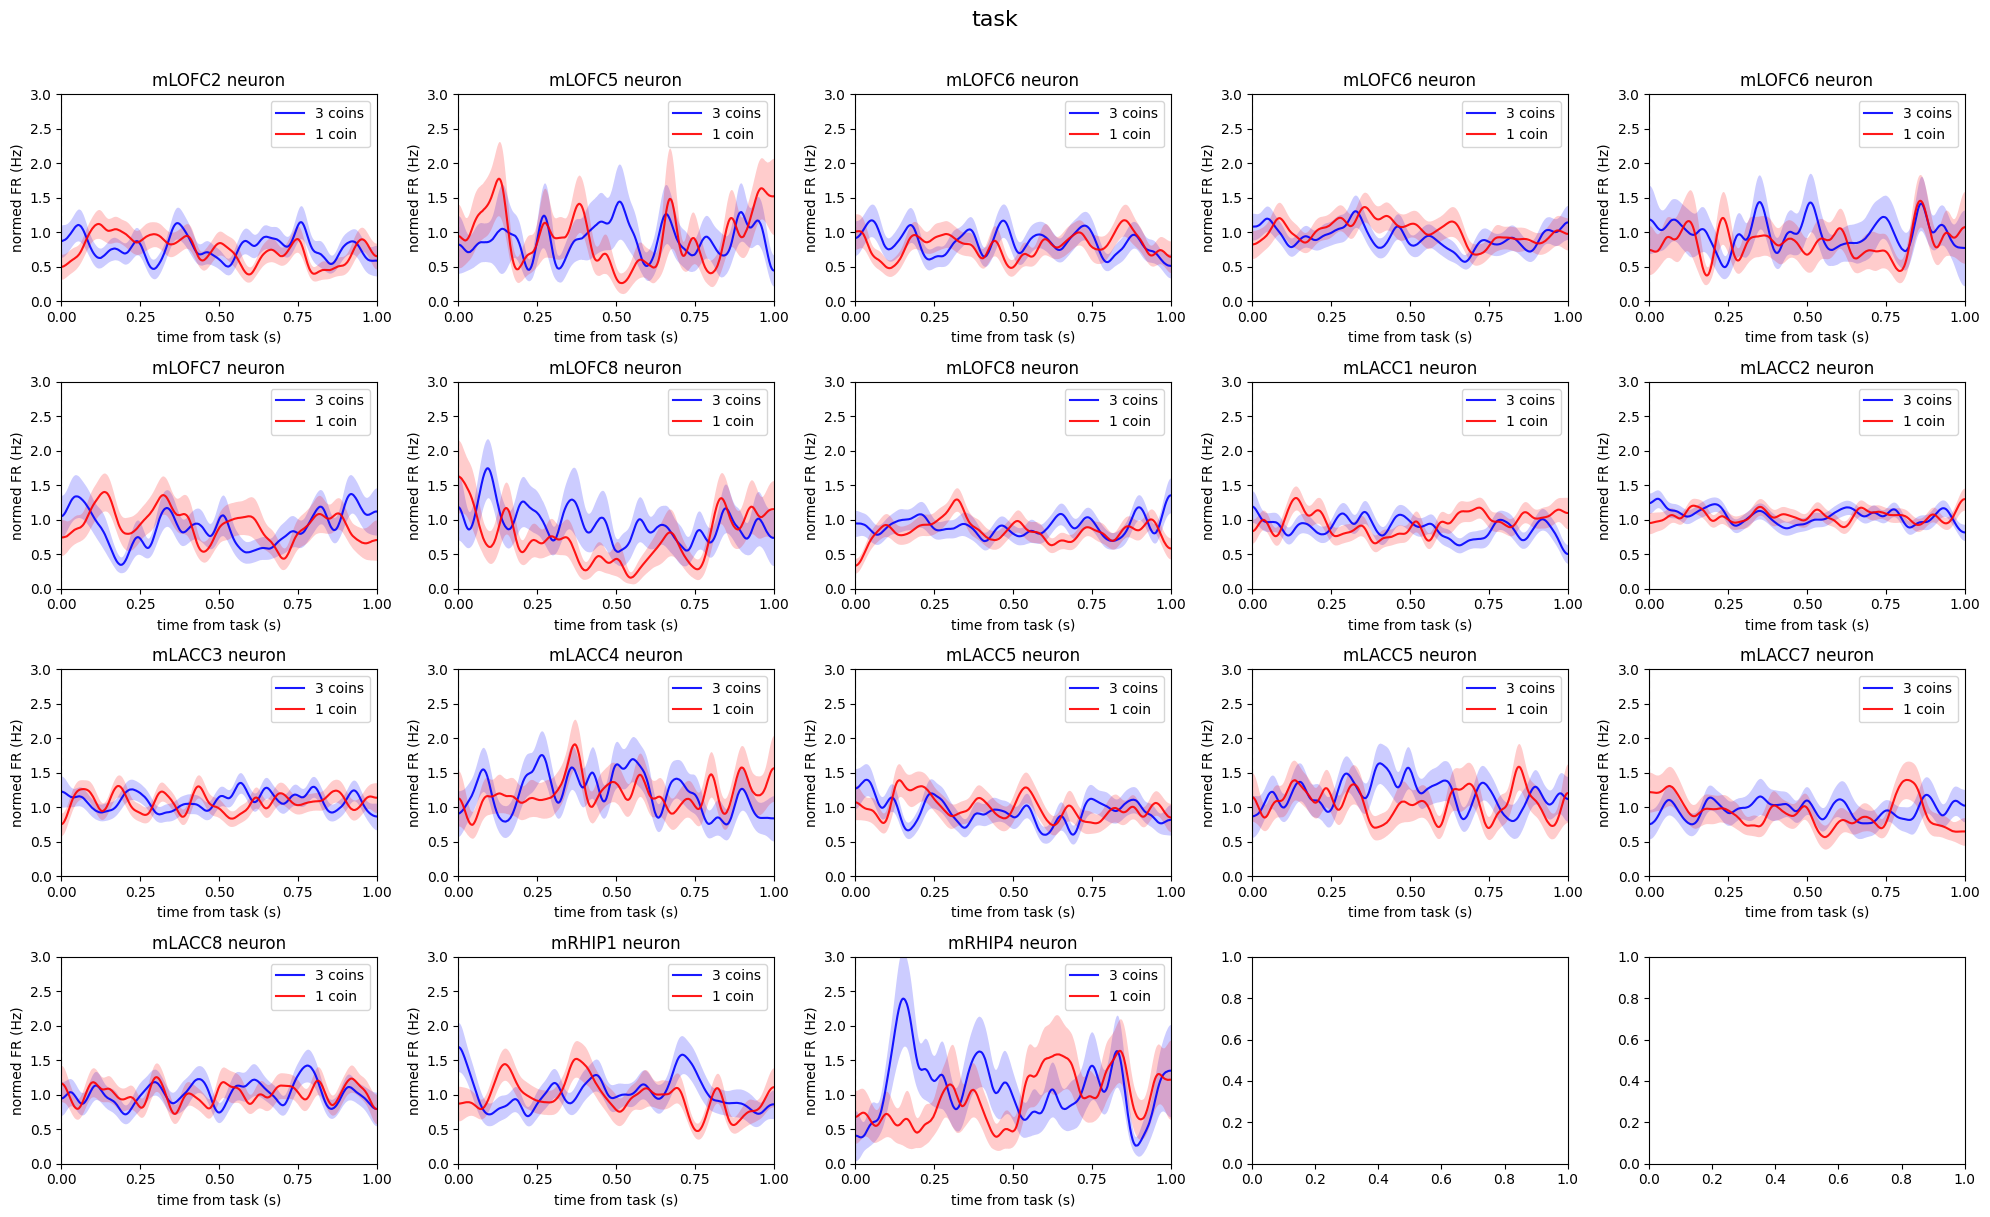

In [81]:
phase = 'task'
print(f'contrast: {contrast}, phase: {phase}')
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_id in range(n_neurs):

    if neur_id in dropped_neur_ids: continue

    # choose between showing 2 or 3 contrasts
    if contrast!= 'conditions': zipped = zip([cond1_label, cond2_label], [cond1_ids, cond2_ids], ['b', 'r'])
    else: zipped = zip([cond1_label, base_label, cond2_label], [cond1_ids, base_ids, cond2_ids], ['b', 'g', 'r'])

    for contrast_label, contrast_ids, color in zipped:
        data = FRs_normed[phase][contrast_ids, neur_id, :]
        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers[phase], mu, color=color, alpha=0.9, label=contrast_label)
        axs[ax].fill_between(bin_centers[phase], mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} (s)', xticks=np.linspace(-.25, 1.5, 8), xlim=[0, dur[phase]], ylim=[0, 3])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


contrast: outcome, phase: stim


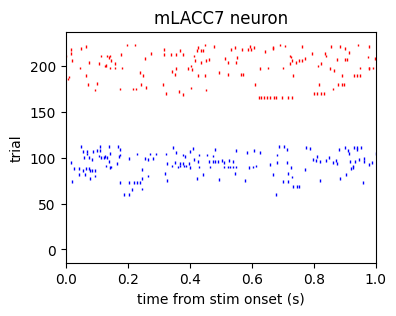

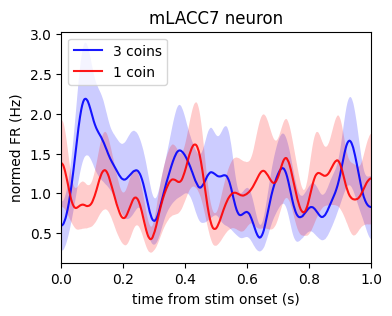

In [28]:
print(f'contrast: {contrast}, phase: {phase}')
# get unique rowID where region = 'mLACC7'. there might be multiple
reg = 'mLACC7'
neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[1]

# raster
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')
if contrast!= 'conditions':
    raster_list = list(spikes[phase][cond1_ids, neur_id]) + list(spikes[phase][cond2_ids, neur_id])
    color_list = ['blue'] * len(cond1_ids) + ['red'] * len(cond2_ids)
else:
    raster_list = list(spikes[phase][cond1_ids, neur_id]) + list(spikes[phase][base_ids, neur_id]) + list(spikes[phase][cond2_ids, neur_id])
    color_list = ['blue'] * len(cond1_ids) + ['black'] * len(base_ids) + ['red'] * len(cond2_ids)
plt.eventplot(raster_list, orientation='horizontal', colors=color_list, linewidths=1.0, linelengths=3.0)
plt.ylabel('trial')
plt.xlabel(f'time from {phase} onset (s)')
plt.xlim([-.0, dur[phase]])
plt.show()

# psth
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')

# choose between showing 2 or 3 contrasts
if contrast!= 'conditions': zipped = zip([cond1_label, cond2_label], [cond1_ids, cond2_ids], ['b', 'r'])
else: zipped = zip([cond1_label, base_label, cond2_label], [cond1_ids, base_ids, cond2_ids], ['b', 'g', 'r'])

for contrast_label, contrast_ids, color in zipped:
    data = FRs_normed[phase][contrast_ids, neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers[phase], mu, color=color, alpha=0.9, label=contrast_label)
    plt.fill_between(bin_centers[phase], mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from {phase} onset (s)')
plt.xlim([-.0, dur[phase]])
plt.legend(loc='upper left')
plt.show()


### phase neurons

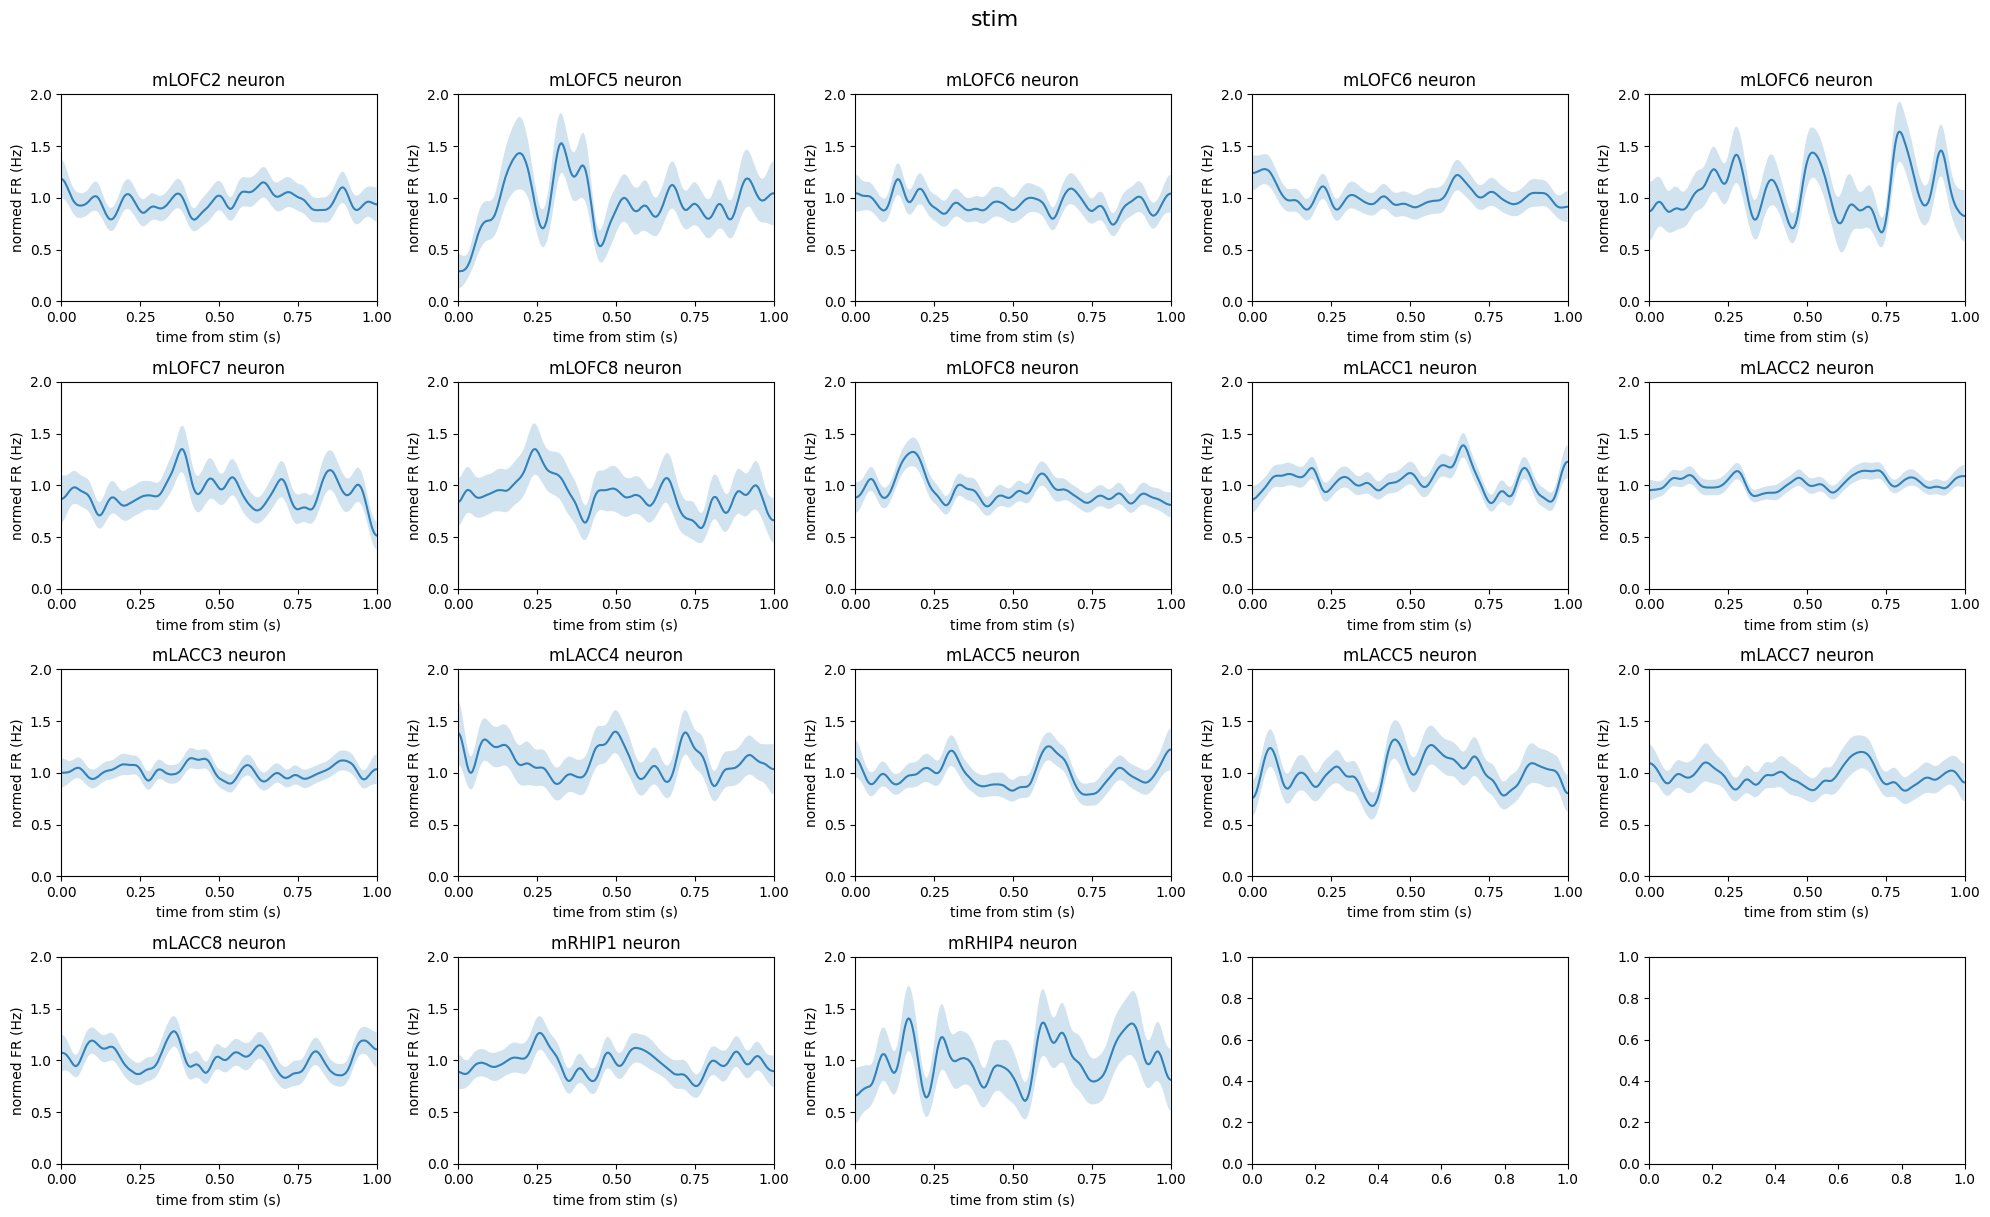

In [54]:
phase = 'stim'
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    if neur_i in dropped_neur_ids: continue
    # no norming for baseline itself
    data = FRs_normed[phase][:, neur_i, :] if phase!='baseline' else FRs[phase][:, neur_i, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    axs[ax].plot(bin_centers[phase], mu, alpha=0.9)
    axs[ax].fill_between(bin_centers[phase], mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
    # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} (s)', xticks=np.linspace(-.25, 1.5, 8), xlim=[0, dur[phase]])
    if phase!='baseline': axs[ax].set(ylim=[0, 2])
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'plot_neur_i' is not defined

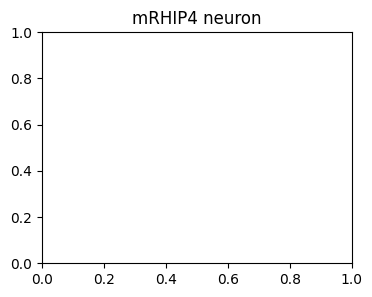

In [24]:
if phase == 'stim': plot_neur_i = 19
elif phase == 'delay': plot_neur_i = 21
elif phase == 'feedback': plot_neur_i = 4

# raster
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
plt.eventplot(spikes[phase][:, plot_neur_i], orientation='horizontal')
plt.axvline(0, color='black', linestyle='-')
plt.ylabel('trial')
plt.xlabel(f'time from {phase} (s)')
plt.xlim([-.0, dur[phase]])
plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_raster.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

# psth
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
data = FRs_normed[phase][:, plot_neur_i, :]
mu = data.mean(axis=0)
sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
plt.plot(bin_centers[phase], mu, alpha=0.9)
plt.fill_between(bin_centers[phase], mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
# plt.axvline(0, color='black', linestyle='-')
plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from {phase} (s)')
plt.xlim([-.0, dur[phase]])
plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_PSTH.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


### duration checks for stim & feedback

In [ ]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()